# CS 584 Assignment 4 -- Sequence to Sequence Models

#### Name: Jose Amezquita

## In this assignment, you are required to follow the steps below:
1. Review the lecture slides.
2. Implement a Seq2Seq model.

*** Please note that there are many online resources for Seq2Seq models, you are allowed to check them, but DO NOT DIRECTLY COPY from them. Otherwise, you will get ZERO for this assignment. ***

In [1]:
from google.colab import drive
drive.mount('/content/drive') #mounts google colab to my drive. Can be commented out when running locally

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/"Colab Notebooks"/"CS584 HW4"

/content/drive/MyDrive/Colab Notebooks/CS584 HW4


In [3]:
%pwd

'/content/drive/MyDrive/Colab Notebooks/CS584 HW4'

In [4]:
# !pip uninstall tensorflow

In [5]:
!pip install tensorflow==2.4.0 #this is the version of tensorflow that I used. I was getting strange errors with tensorflow 2.8

     |████████████████████████████████| 394.7 MB 15 kB/s 
     |████████████████████████████████| 2.9 MB 94.7 MB/s 
     |████████████████████████████████| 3.8 MB 57.0 MB/s 
     |████████████████████████████████| 132 kB 77.4 MB/s 
     |████████████████████████████████| 462 kB 70.2 MB/s 
     |████████████████████████████████| 14.8 MB 57.7 MB/s 
  Created wheel for wrapt: filename=wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl size=68715 sha256=79d449b8ff4771581aed323f5f7877595046946812a401eaffba634f259f485c
  Stored in directory: /root/.cache/pip/wheels/62/76/4c/aa25851149f3f6d9785f6c869387ad82b3fd37582fa8147ac6
Successfully built wrapt
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.2.0
    Uninstalling typing-extensions-4.2.0:
      Successfully uninstalled typing-extensions-4.2.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
  Attempting

In [7]:
!pip install numpy==1.19.5

In [11]:
!pip install numpy scikit-learn tqdm matplotlib
!pip install -U spacy
!python -m spacy download en_core_web_sm
!python -m spacy download es_core_news_sm

     |████████████████████████████████| 6.2 MB 4.6 MB/s 
     |████████████████████████████████| 42 kB 1.2 MB/s 
     |████████████████████████████████| 181 kB 61.6 MB/s 
     |████████████████████████████████| 457 kB 64.9 MB/s 
     |████████████████████████████████| 653 kB 52.5 MB/s 
     |████████████████████████████████| 10.1 MB 41.7 MB/s 
     |████████████████████████████████| 58 kB 5.6 MB/s 
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.2.0
    Uninstalling typing-extensions-4.2.0:
      Successfully uninstalled typing-extensions-4.2.0
  Attempting uninstall: catalogue
    Found existing installation: catalogue 1.0.0
    Uninstalling catalogue-1.0.0:
      Successfully uninstalled catalogue-1.0.0
  Attempting uninstall: srsly
    Found existing installation: srsly 1.0.5
    Uninstalling srsly-1.0.5:
      Successfully uninstalled srsly-1.0.5
  Attempting uninstall: smart-open
    Found existing installation: smart-open 6.0.0
    U

     |████████████████████████████████| 12.8 MB 4.7 MB/s 
  Attempting uninstall: en-core-web-sm
    Found existing installation: en-core-web-sm 2.2.5
    Uninstalling en-core-web-sm-2.2.5:
      Successfully uninstalled en-core-web-sm-2.2.5
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
     |████████████████████████████████| 12.9 MB 5.2 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')


In [4]:
import tensorflow as tf
tf.__version__

'2.8.0'

# 1. Data Process
In this section, you are required to 
1. Divide the data into train, validation, and test.
2. Preprocess the text data

**Note:** The default dataset is for Spanish-English. Feel free to change other pairs of languages, you can find them [here](http://www.statmt.org/europarl/).

In [4]:
import numpy as np
from tqdm.notebook import tqdm

def load_data(filepath):
    texts = []
    with open(filepath, 'r', encoding='utf-8') as f:
        count = len(f.readlines())
        
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in tqdm(f, total=count):
            texts.append(line.strip())
            
    return np.array(texts[:20000])

sources = load_data('training.en') #changed path to my files
targets = load_data('training.fr') #changed path to my files

print('English sentences size:', sources.shape)
print('French sentences size:', targets.shape)

  0%|          | 0/2249121 [00:00<?, ?it/s]

  0%|          | 0/2249121 [00:00<?, ?it/s]

English sentences size: (20000,)
French sentences size: (20000,)


## 1.1 Divide the data into train, validation, and test

In [5]:
from sklearn.model_selection import train_test_split

source_train, source_test, target_train, target_test = train_test_split(sources, targets, test_size=0.2)
source_train, source_valid, target_train, target_valid = train_test_split(source_train, target_train, test_size=0.2)

train_texts = [(sent_source, sent_target) for sent_source, sent_target in zip(source_train, target_train)]
valid_texts = [(sent_source, sent_target) for sent_source, sent_target in zip(source_valid, target_valid)]
test_texts = [(sent_source, sent_target) for sent_source, sent_target in zip(source_test, target_test)]

print('The size of training set:', len(train_texts))
print('The size of valid set:', len(valid_texts))
print('The size of test set:', len(test_texts))

The size of training set: 12800
The size of valid set: 3200
The size of test set: 4000


## 1.2 Data preprocessing
1. Lowercase the text
2. Tokenize the text
3. Create vocabulary for the source language and target language, respectively.

In [6]:
import re
import string
import spacy
from itertools import chain
from unicodedata import normalize, category

nlp_en = spacy.load('en_core_web_sm')
nlp_es = spacy.load('es_core_news_sm')

def tokenize_en(text):
    # text = re.sub(r'’', '\'', text) # some of texts contain invalid apostrophes, such as ’
    # text = normalize('NFD', text).encode('ascii', 'ignore').decode('UTF-8')
    # text = re.sub(r'([.!.?])', r' \1', text)
    # text = re.sub(r'[^a-zA-Z-]', r' ', text)
    # tokens = text.lower().strip().split()
    doc = nlp_en(text.lower())
    return [token.text for token in doc]
    # return tokens

def tokenize_es(text):
    doc = nlp_es(text.lower())
    return [token.text for token in doc]

def preprocess(texts, type='en'):
    if type == 'en':
        return [tokenize_en(text) for text in tqdm(texts, desc='en')]
    elif type == 'es':
        return [tokenize_es(text) for text in tqdm(texts, desc='es')]

def generate_vocab(tokenized_texts):
    # Flatten the input to 1d array, Thanks for: 
    # https://stackoverflow.com/questions/29244286/how-to-flatten-a-2d-list-to-1d-without-using-numpy
    vocab = list(chain.from_iterable(tokenized_texts))
    return list(set(vocab))

source_tokens = preprocess(source_train, 'en')
target_tokens = preprocess(target_train, 'es')

source_vocab = generate_vocab(source_tokens)
source_vocab.insert(0, '<unk>')
source_token2idx = {token: idx for idx, token in enumerate(source_vocab)}

target_vocab = generate_vocab(target_tokens)
target_vocab.insert(0, '<end>')
target_vocab.insert(0, '<start>')
target_vocab.insert(0, '<unk>')
target_token2idx = {token: idx for idx, token in enumerate(target_vocab)}

print('English vocab size:', len(source_vocab))
print('French vocab size:', len(target_vocab))

en:   0%|          | 0/12800 [00:00<?, ?it/s]

es:   0%|          | 0/12800 [00:00<?, ?it/s]

English vocab size: 15585
French vocab size: 19712


In [7]:
train_set = [([source_token2idx[t] for t in tokenize_en(source)], [target_token2idx[t] for t in tokenize_es(target)]) for source, target in train_texts]
valid_set = [([source_token2idx[t] if t in source_token2idx else 0 for t in tokenize_en(source)], [target_token2idx[t] if t in target_token2idx else 0 for t in tokenize_es(target)]) for source, target in valid_texts]
test_set = [([source_token2idx[t] if t in source_token2idx else 0 for t in tokenize_en(source)], [target_token2idx[t] if t in target_token2idx else 0 for t in tokenize_es(target)]) for source, target in test_texts]


In [8]:
#check what the vocab looks like
print(source_vocab[:20])
print(target_vocab[:20])

['<unk>', 'operate', 'ball', 'деп', 'merusak', 'to', 'asked', 'inec', 'regeneration', 'itself', 'austria', 'tempus', 'utilities', 'spill', 'pessoa', 'morals', 'painkillers', 'confiscation', 'haste', 'macedonian']
['<unk>', '<start>', '<end>', 'photographies', 'locaux', 'tempus', 'alloue', 'téléphone', 'accroissement', 'parlant', 'indien', 'porte-conteneurs', 'influencer', 'warren', 'veut', 'appellerons', 'légitimer', 'roll', 'éventuels', 'pesticides']


## 2. Seq2Seq Model (50 points)
In this section, you are required to 
1. Implement a seq2seq model which includes a CNN encoder and an RNN based decoder.  
2. For each RNN cell, try a simple RNN, LSTM, and GRU.  
3. Use the validation set to compute the BLEU score and report the best choice.

**Note:** you could use any package you are comfortable with, such as PyTorch and TensorFlow.

### 2.1 Encoder (25 points)

Try a simple RNN, LSTM, and GRU

In [10]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt 
from nltk.translate.bleu_score import sentence_bleu

In [11]:
np.__version__

'1.19.5'

In [12]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

Num GPUs Available:  1
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5327963622875617912
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14619084096
locality {
  bus_id: 1
  links {
  }
}
incarnation: 444154873461386751
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


In [19]:
source_vocab_size = len(source_vocab)
target_vocab_size = len(target_vocab)
embedding_size = 300 #size of the embedding layer
hidden_size = 300 #size of the hidden layer

In [20]:
#simple RNN
simple_RNN_inputs = layers.Input(shape=(None,)) #The input layer of the encoder. Takes in a sentence in english tokenized
simple_RNN_embedding = layers.Embedding(input_dim=source_vocab_size, output_dim=embedding_size) #add an embedding layer to help get better results
simple_RNN_embedding_with_Inputs = simple_RNN_embedding(simple_RNN_inputs) #Apply the embedding layer to the inputs
simple_RNN_encoder = layers.SimpleRNN(hidden_size, return_state=True, dropout=0.25) #add a simpleRNN layer. This is the part that changes in each model
encoder_outputs, encoder_context_vector = simple_RNN_encoder(simple_RNN_embedding_with_Inputs)#apply the simpleRNN layer to the embedding layer output
simple_RNN_encoder_states = [encoder_context_vector]#the result of the encoder in list form

print((simple_RNN_encoder_states))

[<KerasTensor: shape=(None, 300) dtype=float32 (created by layer 'simple_rnn')>]


In [22]:
#LSTM
lstm_inputs = layers.Input(shape=(None,))#The input layer of the encoder. Takes in a sentence in english tokenized
lstm_embedding =layers.Embedding(input_dim=source_vocab_size, output_dim=embedding_size)#add an embedding layer to help get better results
lstm_embedding_with_inputs = lstm_embedding(lstm_inputs)#Apply the embedding layer to the inputs
lstm_encoder = layers.LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.25) #add a LSTM layer
_, lstm_state_h, lstm_state_c = lstm_encoder(lstm_embedding_with_inputs)#apply the LSTM layer to the embedding layer and store the hidden state and cell state
lstm_encoder_states = [lstm_state_h, lstm_state_c]#set the hidden state and cell states as the encoder output

print(lstm_encoder_states)

[<KerasTensor: shape=(None, 300) dtype=float32 (created by layer 'lstm')>, <KerasTensor: shape=(None, 300) dtype=float32 (created by layer 'lstm')>]


In [ ]:
#GRU
gru_inputs = layers.Input(shape=(None,))#The input layer of the encoder. Takes in a sentence in english tokenized
gru_embedding =layers.Embedding(input_dim=source_vocab_size, output_dim=embedding_size)#add an embedding layer to help get better results
gru_embedding_with_inputs = gru_embedding(gru_inputs)#Apply the embedding layer to the inputs
gru_encoder = layers.GRU(hidden_size, return_state=True, dropout=0.25)#Add a GRU layer.
_, gru_context_vec = gru_encoder(gru_embedding_with_inputs)#Apply the GRU layer to the embedding layer
gru_encoder_states = [gru_context_vec]#save the context vec output as a list

print(gru_encoder_states)

[<KerasTensor: shape=(None, 300) dtype=float32 (created by layer 'gru')>]


### 2.2 CNN Encoder (Extra Credit)

A traditional encoder of Seq2Seq models is an RNN-based model, such as RNN, LSTM, or GRU. But CNNs can also be encoders. In this sub-section, you need to implement a CNN encoder for your Seq2Seq model.

**Hint:** We already learned how CNN can be applied to sentence classification tasks. You can simply drop the last layer of TextCNN and output the context vector. Please check this [paper](https://arxiv.org/abs/1510.03820) for details.

In [ ]:
#I will attempt later

### 2.3 Decoder (25 points)
Try a simple RNN, LSTM, and GRU

In [23]:
#LSTM Decoder
lstm_decoder_input = layers.Input(shape=(None,))#The input layer of the decoder. It takes in the translated sentence with a start token and the sentence tokenized
lstm_decoder_embedding = layers.Embedding(input_dim=target_vocab_size, output_dim=embedding_size)#add an embedding layer
lstm_decoder_embedding_with_Inputs = lstm_decoder_embedding(lstm_decoder_input)#apply the embedding layer to the input layer
lstm_decoder = layers.LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.25)#add an lstm layer and return sequences is true, since we want the predictions at each timestep
lstm_decoder_outputs, _, _ = lstm_decoder(lstm_decoder_embedding_with_Inputs, initial_state=lstm_encoder_states)#apply the lstm layer to the embedding layer and set the initial state as the encoder context vector
lstm_dense = layers.Dense(target_vocab_size, activation="softmax")#finally add a dense layer with softmax prediction function to predict the probabilities for each word
lstm_decoder_outputs = lstm_dense(lstm_decoder_outputs)#apply the dense layer to the output of the lstm layer

print(lstm_decoder_outputs)

KerasTensor(type_spec=TensorSpec(shape=(None, None, 19368), dtype=tf.float32, name=None), name='dense_1/truediv:0', description="created by layer 'dense_1'")


In [21]:
#simpleRNN Decoder
simpleRNN_decoder_input = layers.Input(shape=(None,))#The input layer of the decoder. It takes in the translated sentence with a start token and the sentence tokenized
simpleRNN_decoder_embedding = layers.Embedding(input_dim=target_vocab_size, output_dim=embedding_size)#add embedding layer
simpleRNN_decoder_embedding_with_Inputs = simpleRNN_decoder_embedding(simpleRNN_decoder_input)#apply embedding layer to input layer
simpleRNN_decoder = layers.SimpleRNN(hidden_size, return_sequences=True, return_state=True, dropout=0.25)#add simpleRNN layer and return sequences is true since we want the predictions at each timestep
simpleRNN_decoder_outputs, _ = simpleRNN_decoder(simpleRNN_decoder_embedding_with_Inputs, initial_state=simple_RNN_encoder_states)#apply the simpleRNN layer to the embedding layer and set the initial state as the context vector from the encoder
simpleRNN_dense = layers.Dense(target_vocab_size, activation="softmax")#add a dense layer with activaiton function as softmax
simpleRNN_decoder_outputs = simpleRNN_dense(simpleRNN_decoder_outputs)#appy the dense layer to the simpleRNN layer

print(simpleRNN_decoder_outputs)

KerasTensor(type_spec=TensorSpec(shape=(None, None, 19712), dtype=tf.float32, name=None), name='dense/Softmax:0', description="created by layer 'dense'")


In [ ]:
#GRU Decoder
gru_decoder_input = layers.Input(shape=(None,))#The input layer of the decoder. It takes in the translated sentence with a start token and the sentence tokenized
gru_decoder_embedding = layers.Embedding(input_dim=target_vocab_size, output_dim=embedding_size)#add embedding layer
gru_decoder_embedding_with_Inputs = gru_decoder_embedding(gru_decoder_input)#apply embedding layer to input layer
gru_decoder = layers.GRU(hidden_size, return_sequences=True, return_state=True, dropout=0.25)#add GRU layer with return sequences true to get predictions at each timestep
gru_decoder_outputs, _ = gru_decoder(gru_decoder_embedding_with_Inputs, initial_state=gru_encoder_states)#apply GRU layer to embedding layer and set the initial state as the context vecotr of the encoder
gru_dense = layers.Dense(target_vocab_size, activation="softmax")#add dense layer with softmax activation function
gru_decoder_outputs = gru_dense(gru_decoder_outputs)#apply the dense layer to the GRU layer

print(gru_decoder_outputs)

KerasTensor(type_spec=TensorSpec(shape=(None, None, 19620), dtype=tf.float32, name=None), name='dense_2/truediv:0', description="created by layer 'dense_2'")


## 3. Training your Seq2Seq (30 points)
1. Implement training process
2. Use validation set to calculate BLEU score
3. Plot your training loss and validation loss (You could use the code in assignment 1)

In [24]:
learning_rate = 0.001#set learning rate
batch_size = 64#set batch size
num_epochs = 15#set number of epochs

In [11]:
#pad sentences so they are all the same length

#get the max lengths of the target and the source texts for training, validation and test sets. 
max_source_len_train = max([len(translation[0]) for translation in train_set])
max_target_len_train = max([len(translation[1]) for translation in train_set])
max_source_len_val = max([len(translation[0]) for translation in valid_set])
max_target_len_val = max([len(translation[1]) for translation in valid_set])
max_source_len_test = max([len(translation[0]) for translation in test_set])
max_target_len_test = max([len(translation[1]) for translation in test_set])

#encoder input -> sentences in english
#decoder intput -> <START> sentence in target language
#decoder output -> sentence in target language <END>

#get the encoder input, decoder input, and decoder output as outlined above for the training, test, and validation sets and pad them to the max lengths
encoder_input = [translation[0] for translation in train_set]
encoder_input = pad_sequences(encoder_input, maxlen=max_source_len_train, padding="post")
decoder_input = [[target_token2idx["<start>"]]+translation[1] for translation in train_set]
decoder_input = pad_sequences(decoder_input, maxlen=max_target_len_train+1, padding="post")
decoder_output = [translation[1]+[target_token2idx["<end>"]] for translation in train_set]
decoder_output = pad_sequences(decoder_output, maxlen=max_target_len_train+1, padding="post")

val_encoder_input = [translation[0] for translation in valid_set]
val_encoder_input = pad_sequences(val_encoder_input, maxlen=max_source_len_val, padding="post")
val_decoder_input = [[target_token2idx["<start>"]]+translation[1] for translation in valid_set]
val_decoder_input = pad_sequences(val_decoder_input, maxlen=max_target_len_val+1, padding="post")
val_decoder_output = [translation[1]+[target_token2idx["<end>"]] for translation in valid_set]
val_decoder_output = pad_sequences(val_decoder_output, maxlen=max_target_len_val+1, padding="post")

test_encoder_input = [translation[0] for translation in test_set]
test_encoder_input = pad_sequences(test_encoder_input, maxlen=max_source_len_test, padding="post")
test_decoder_input = [[target_token2idx["<start>"]]+translation[1] for translation in test_set]
test_decoder_input = pad_sequences(test_decoder_input, maxlen=max_target_len_test+1, padding="post")
test_decoder_output = [translation[1]+[target_token2idx["<end>"]] for translation in test_set]
test_decoder_output = pad_sequences(test_decoder_output, maxlen=max_target_len_test+1, padding="post")

In [27]:
print(encoder_input)
print(decoder_input.shape)
print(decoder_output.shape)

[[ 3974  6015  9427 ...     0     0     0]
 [11680  2094  8172 ...     0     0     0]
 [ 2223 14111  5629 ...     0     0     0]
 ...
 [12586  8702   191 ...     0     0     0]
 [11735  9427 14341 ...     0     0     0]
 [ 6343 12595 14734 ...     0     0     0]]
(12800, 111)
(12800, 111)


In [ ]:
#for testing purposes, use less data
# encoder_input = encoder_input[:5000]
# decoder_input = decoder_input[:5000]
# decoder_output = decoder_output[:5000]

# val_encoder_input = val_encoder_input[:1250]
# val_decoder_input = val_decoder_input[:1250]
# val_decoder_output = val_decoder_output[:1250]

In [22]:
#lstm training
lstm_model = keras.models.Model([lstm_inputs, lstm_decoder_input], lstm_decoder_outputs)#define the model LSTM

lstm_model.compile(loss="sparse_categorical_crossentropy", optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate), metrics = ['accuracy'])#compile the model. Used Adam because that was what i used in hw 3

lstm_model.summary()

NameError: ignored

In [25]:
#fit the model and save the history
lstm_hist = lstm_model.fit([encoder_input, decoder_input], 
          decoder_output, epochs=num_epochs, 
          batch_size=batch_size, 
          validation_data=([val_encoder_input, val_decoder_input], val_decoder_output))

Epoch 1/15
200/200 [==============================] - 60s 239ms/step - loss: 3.9453 - accuracy: 0.6827 - val_loss: 1.8267 - val_accuracy: 0.7252
Epoch 2/15
200/200 [==============================] - 48s 240ms/step - loss: 1.8392 - accuracy: 0.7343 - val_loss: 1.6439 - val_accuracy: 0.7515
Epoch 3/15
200/200 [==============================] - 49s 244ms/step - loss: 1.6367 - accuracy: 0.7547 - val_loss: 1.5433 - val_accuracy: 0.7582
Epoch 4/15
200/200 [==============================] - 49s 246ms/step - loss: 1.5237 - accuracy: 0.7628 - val_loss: 1.4666 - val_accuracy: 0.7655
Epoch 5/15
200/200 [==============================] - 49s 246ms/step - loss: 1.4479 - accuracy: 0.7683 - val_loss: 1.4061 - val_accuracy: 0.7709
Epoch 6/15
200/200 [==============================] - 49s 247ms/step - loss: 1.3755 - accuracy: 0.7743 - val_loss: 1.3639 - val_accuracy: 0.7737
Epoch 7/15
200/200 [==============================] - 49s 247ms/step - loss: 1.3189 - accuracy: 0.7779 - val_loss: 1.3341 - val_ac

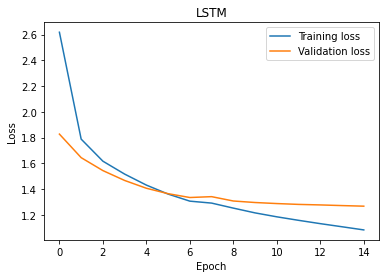

In [26]:
#LSTM Plot
lstm_train_loss = lstm_hist.history["loss"]
lstm_val_loss = lstm_hist.history["val_loss"]
plt.plot(range(num_epochs), lstm_train_loss, lstm_val_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(["Training loss", "Validation loss"])
plt.title('LSTM')
plt.show()

In [25]:
#SimpleRNN Training
simpleRNN_model = keras.models.Model([simple_RNN_inputs, simpleRNN_decoder_input], simpleRNN_decoder_outputs)#define the model simpleRNN

simpleRNN_model.compile(loss="sparse_categorical_crossentropy", optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate), metrics = ['accuracy'])#compile the model

simpleRNN_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 300)    4675500     ['input_2[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, None, 300)    5913600     ['input_3[0][0]']                
                                                                                            

In [21]:
# np.asarray([encoder_input, decoder_input])

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


ValueError: ignored

In [26]:
#fit the model
simpleRNN_hist = simpleRNN_model.fit([encoder_input, decoder_input], 
          decoder_output, epochs=num_epochs, 
          batch_size=batch_size, 
          validation_data=([val_encoder_input, val_decoder_input], val_decoder_output))

Epoch 1/15


KeyboardInterrupt: ignored

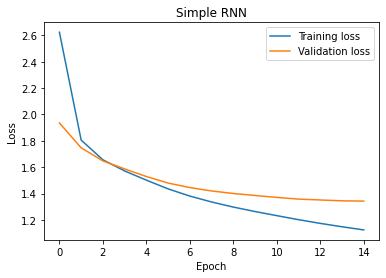

In [ ]:
#SimpleRNN Plot
simpleRNN_train_loss = simpleRNN_hist.history["loss"]
simpleRNN_val_loss = simpleRNN_hist.history["val_loss"]
plt.plot(range(num_epochs), lstm_train_loss, lstm_val_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(["Training loss", "Validation loss"])
plt.title('Simple RNN')
plt.show()

In [ ]:
#GRU Training
gru_model = keras.models.Model([gru_inputs, gru_decoder_input], gru_decoder_outputs)#define the model GRU

gru_model.compile(loss="sparse_categorical_crossentropy", optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate), metrics = ['accuracy'])#compile the model

gru_model.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 300)    4678800     input_3[0][0]                    
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, None, 300)    5886000     input_6[0][0]                    
___________________________________________________________________________________________

In [ ]:
#fit the model
gru_hist = gru_model.fit([encoder_input, decoder_input], 
          decoder_output, epochs=num_epochs, 
          batch_size=batch_size, 
          validation_data=([val_encoder_input, val_decoder_input], val_decoder_output))

Epoch 1/15
200/200 [==============================] - 45s 210ms/step - loss: 0.9649 - accuracy: 0.8037 - val_loss: 1.4560 - val_accuracy: 0.7728
Epoch 2/15
200/200 [==============================] - 41s 207ms/step - loss: 0.8915 - accuracy: 0.8125 - val_loss: 1.4720 - val_accuracy: 0.7733
Epoch 3/15
200/200 [==============================] - 41s 207ms/step - loss: 0.8622 - accuracy: 0.8169 - val_loss: 1.4821 - val_accuracy: 0.7736
Epoch 4/15
200/200 [==============================] - 41s 206ms/step - loss: 0.8209 - accuracy: 0.8236 - val_loss: 1.5067 - val_accuracy: 0.7737
Epoch 5/15
200/200 [==============================] - 41s 207ms/step - loss: 0.8076 - accuracy: 0.8246 - val_loss: 1.5173 - val_accuracy: 0.7739
Epoch 6/15
200/200 [==============================] - 41s 206ms/step - loss: 0.7674 - accuracy: 0.8319 - val_loss: 1.5296 - val_accuracy: 0.7741
Epoch 7/15
200/200 [==============================] - 41s 206ms/step - loss: 0.7510 - accuracy: 0.8343 - val_loss: 1.5462 - val_ac

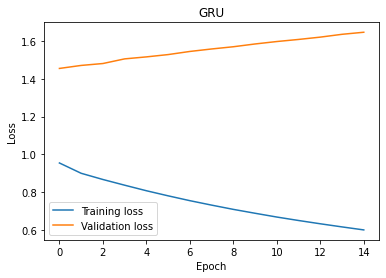

In [ ]:
#GRU Plot
gru_train_loss = gru_hist.history["loss"]
gru_val_loss = gru_hist.history["val_loss"]
plt.plot(range(num_epochs), gru_train_loss, gru_val_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(["Training loss", "Validation loss"])
plt.title('GRU')
plt.show()

In [27]:
#lstm encoder and decoder models
lstm_encoder_model = keras.models.Model(lstm_inputs, lstm_encoder_states) #define the encoder with the trainined weights

lstm_encoder_model.summary()
#get the decoder model
lstm_decoder_state_h = layers.Input(shape=(hidden_size,))#initialize the inputs for the hidden state from the encoder
lstm_decoder_state_c = layers.Input(shape=(hidden_size,))#initialize the inputs for the cell state from the encoder
lstm_decoder_states_inputs = [lstm_decoder_state_h, lstm_decoder_state_c]#context vector from the encoder as the input
decoder_outputs_lstm, state_h, state_c = lstm_decoder(lstm_decoder_embedding_with_Inputs, initial_state = lstm_decoder_states_inputs)#apply the trainined decoder to the embedding layer
decoder_states_lstm = [state_h, state_c]#output of the decoder as a vector
decoder_outputs_lstm = lstm_dense(decoder_outputs_lstm)#apply the dense layer to the outputs of the decoder
lstm_decoder_model = keras.models.Model([lstm_decoder_input]+lstm_decoder_states_inputs, [decoder_outputs_lstm]+decoder_states_lstm)#set the decoder model with inputs as the dcoder inputs plus the encoder context vector. and the outputs as the decoder output plus the context vector

lstm_decoder_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_2 (Embedding)      (None, None, 300)         4650900   
_________________________________________________________________
lstm (LSTM)                  [(None, None, 300), (None 721200    
Total params: 5,372,100
Trainable params: 5,372,100
Non-trainable params: 0
_________________________________________________________________
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, None)]       0                                            
_________________________________________________________________

In [ ]:
#simpleRNN encoder and decoder models
simpleRNN_encoder_model = keras.models.Model(simple_RNN_inputs, simple_RNN_encoder_states)#define the encoder with the trainined weights

simpleRNN_encoder_model.summary()
#get the encoder model
simpleRNN_decoder_state = layers.Input(shape=(hidden_size,))#initialize the input for the context vector from the encoder
simpleRNN_decoder_states_inputs = [simpleRNN_decoder_state]#set context vector as a list
decoder_outputs_simpleRNN, return_state = simpleRNN_decoder(simpleRNN_decoder_embedding_with_Inputs, initial_state = simpleRNN_decoder_states_inputs)#apply the trained simpleRNN decoder to the embedding with the initial state as the encoder context vector
decoder_states_simpleRNN = [return_state]#save the output as a list
decoder_outputs_simpleRNN = simpleRNN_dense(decoder_outputs_simpleRNN)#apply the dense layer
simpleRNN_decoder_model = keras.models.Model([simpleRNN_decoder_input]+simpleRNN_decoder_states_inputs, [decoder_outputs_simpleRNN]+decoder_states_simpleRNN)#set the decoder model with inputs as the dcoder inputs plus the encoder context vector. and the outputs as the decoder output plus the context vector

simpleRNN_decoder_model.summary()

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 300)         4678800   
_________________________________________________________________
simple_rnn (SimpleRNN)       [(None, 300), (None, 300) 180300    
Total params: 4,859,100
Trainable params: 4,859,100
Non-trainable params: 0
_________________________________________________________________
Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, None)]       0                                            
_______________________________________________________________

In [ ]:
#GRU inference
gru_encoder_model = keras.models.Model(gru_inputs, gru_encoder_states, name="GRU_Encoder")#define the encoder with the trainined weights

gru_encoder_model.summary()
#get the decoder model
gru_decoder_state = layers.Input(shape=(hidden_size,))#initialize the input for the context vector from the encoder
gru_decoder_states_inputs = [gru_decoder_state]#set context vector as a list
decoder_outputs_gru, return_state = gru_decoder(gru_decoder_embedding_with_Inputs, initial_state = gru_decoder_states_inputs)#apply the trained GRU decoder to the embedding with the initial state as the encoder context vector
decoder_states_gru = [return_state]#save the output as a list
decoder_outputs_gru = gru_dense(decoder_outputs_gru)#apply the dense layer
gru_decoder_model = keras.models.Model([gru_decoder_input]+gru_decoder_states_inputs, [decoder_outputs_gru]+decoder_states_gru, name="Gru_Decoder")#set the decoder model with inputs as the dcoder inputs plus the encoder context vector. and the outputs as the decoder output plus the context vector

gru_decoder_model.summary()

Model: "GRU_Encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_2 (Embedding)      (None, None, 300)         4678800   
_________________________________________________________________
gru (GRU)                    [(None, 300), (None, 300) 541800    
Total params: 5,220,600
Trainable params: 5,220,600
Non-trainable params: 0
_________________________________________________________________
Model: "Gru_Decoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, None)]       0                                            
_________________________________________________________

In [28]:
def decode(encoder_model, decoder_model, input_sequence, maxlen, lstm):
    # input_sequence = np.reshape(input_sequence, (-1, 1, maxlen))
    states_value = encoder_model.predict(input_sequence)#get the context vector from the encoder
    end = False#set the end condition as false
    greedy_sentence = np.array([])#this is the sentence so fat
    decoder_input = np.array([target_token2idx["<start>"]])#start the translation from the <start> tag
    # decoder_model.summary()
    # print(np.shape(states_value))
    # print([decoder_input]+states_value)

    #while we have not reached an end tag or max length
    while not end:
        if lstm:
          predictions, h, c = decoder_model.predict([decoder_input] + states_value)#if its an lstm predict the probabilities of words and save the ouputs
        else:
          predictions, return_state = decoder_model.predict([decoder_input]+[states_value])#if its not an lstm predict the probabilities of words and save the output
            
        greedy = np.argmax(predictions[0, -1, :])#take the word with the highest probability (GREEDY)
        predicted_word = target_vocab[greedy]#get the word in the target language
        
        greedy_sentence = np.append(greedy_sentence, predicted_word)#add the word to the sentence so far
        end=predicted_word=="<end>" or len(greedy_sentence)>=maxlen#check if we should end
        decoder_input = np.array([greedy])#the predicted word is the next decoder input
        states_value = [h,c] if lstm else [return_state]#the context vector of the predicted word
    # print(greedy_sentence)    
    return greedy_sentence 

In [ ]:
# def beam_decoder(encoder_model, decoder_model, input_sequence, timesteps, num_hypotheses, lstm):
#     states_value = encoder_model.predict(input_sequence)
#     beam_all_values = np.array([])
#     decoder_inputs = np.array([[target_token2idx["<start>"]]])
#     i = 0
#     while i < timesteps and len(beam_all_values) < num_hypotheses:
#         for d_input in decoder_inputs:
#             if lstm:
#                 predictions, h, c = decoder_model.predict([d_input]+states_value)
#             else:
#                 predictions, return_state = decoder_model.predict([d_input]+[states_value])

            

In [ ]:
decode(gru_encoder_model, gru_decoder_model, test_encoder_input[3:4], max_source_len_test, lstm=False)

array(['je', 'suis', 'favorable', 'à', 'la', 'nécessité', 'de',
       'procéder', 'à', 'la', 'nécessité', 'de', 'la', 'nécessité', 'de',
       'réaliser', 'les', 'principes', 'de', 'la', 'sûreté', 'et', 'de',
       'la', 'sécurité', '.', '<end>'], dtype='<U32')

In [29]:
decode(lstm_encoder_model, lstm_decoder_model, test_encoder_input[3:4], max_source_len_test, lstm=True)

array(['je', 'voudrais', 'dire', 'que', 'la', 'commission', 'a', 'été',
       'adoptée', 'par', 'le', 'parlement', ',', 'qui', 'a', 'été',
       'adoptée', 'par', 'le', 'parlement', ',', 'qui', 'a', 'été', 'dit',
       ',', 'je', 'voudrais', 'dire', 'que', 'la', 'commission', 'a',
       'été', 'adoptée', 'par', 'le', 'parlement', ',', 'qui', 'a', 'été',
       'dit', ',', 'à', 'la', 'commission', ',', 'et', 'je', 'suis',
       'heureux', 'que', 'nous', 'avons', 'besoin', 'd', "'", 'une',
       'politique', 'de', 'la', 'commission', '.', '<end>'], dtype='<U32')

In [ ]:
input = np.array([test_encoder_input[3]])
decode(simpleRNN_encoder_model, simpleRNN_decoder_model, input, max_source_len_test, lstm=False)

array(['je', 'voudrais', 'souligner', 'que', 'la', 'commission', 'a',
       'déjà', 'été', 'dit', ',', 'mais', 'je', 'ne', 'suis', 'pas',
       'eurofédéraliste', '-', 'et', 'je', 'suis', 'convaincu', 'que',
       'nous', 'avons', 'besoin', 'd', "'", 'une', 'politique', 'de',
       'voisinage', '.', '<end>'], dtype='<U32')

In [ ]:
# print([test_encoder_input[0]])

print(valid_texts[3][1].split(' '))
print(test_texts[3:4])
# [[source_token2idx["hi"], source_token2idx["there"]]]

['cela', 'permettre', 'à', 'chaque', 'pays', 'de', 'disposer', 'de', 'sa', 'capacité', 'de', 'recyclage', 'optimale', 'car', 'chaque', 'producteur', 'de', 'matériaux', 'aura', 'intérêt', 'à', 'recycler', '.']
[('i am aware of the efforts that were made in the negotiations between parliament and the council aimed at achieving agreement at the first reading .', "j' ai conscience des efforts consentis dans les négociations entre le parlement et le conseil en vue d' obtenir un accord en première lecture .")]


In [ ]:
def calc_bleu_score(num_samples,encoder_model, decoder_model, data_input,data_output, maxlen, lstm):
    score = 0
    for i in tqdm(range(num_samples)): #using the entire data set was supposed to take 40 minutes, so i used a sample size to make the run time more reasonable, 100 samples was about 2 minutes
        predicted_translation = decode(encoder_model, decoder_model, np.array([data_input[i]]), maxlen, lstm)#predict the sentence
        ground_truth = data_output[i][1].split(' ')#get the fround truth as a list
        score += sentence_bleu([ground_truth], predicted_translation)#calculate the bleu score
    score /= len(data_input)#average the bleu score
    print(score)
    return score

In [ ]:
lstm_bleu = calc_bleu_score(300,lstm_encoder_model, lstm_decoder_model, val_encoder_input, valid_texts, max_target_len_val, lstm=True)#calcualte LSTM bleu for validation

  0%|          | 0/300 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


0.04158467033149026


In [ ]:
gru_bleu = calc_bleu_score(300,gru_encoder_model, gru_decoder_model, val_encoder_input, valid_texts, max_target_len_val, lstm=False)#calculate GRU bleu for validation set

  0%|          | 0/300 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


0.03323169794295218


In [ ]:
simpleRNN_bleu = calc_bleu_score(300,simpleRNN_encoder_model, simpleRNN_decoder_model, val_encoder_input, valid_texts, max_target_len_val, lstm=False)#calcualte simpleRNN bleu for validation set

  0%|          | 0/300 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


0.038952829570361246


In [ ]:
#get the model with the best bleu score on the validation set
models = ["LSTM", "GRU", "Simple RNN"]
scores = [lstm_bleu, gru_bleu, simpleRNN_bleu]
best_bleu = np.argmax(scores)

print(f'Best Model: {models[best_bleu]} Score: {scores[best_bleu]}')


Best Model: LSTM Score: 0.04158467033149026


## 4. Evaluation (20 points)
1. Calculate the BLEU scores of the best seq2seq model obtained from section 2&3 on the test set.
2. Select 20 test examples, For each example, print the translation result of your model along with the ground truth

### 4.1 Calculate the BLEU score on test set. (10 points)

In [ ]:
#Print the bleu score of the best model that was predicted on the test set
if models[best_bleu]=="LSTM":
    calc_bleu_score(100,lstm_encoder_model, lstm_decoder_model, test_encoder_input, test_texts, max_target_len_val, lstm=True)
elif models[best_bleu]=="GRU":
    calc_bleu_score(100,gru_encoder_model, gru_decoder_model, test_encoder_input, test_texts, max_target_len_val, lstm=False)
else:
    calc_bleu_score(100,simpleRNN_encoder_model, simpleRNN_decoder_model, test_encoder_input, test_texts, max_target_len_val, lstm=False)

  0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


0.011263490478114075


### 4.2 Translate 20 test exmaples. (10 points)

In [ ]:
#print 20 translations with the best model

if models[best_bleu]=="LSTM":
    for i in range(20):
        predicted_sentence = decode(lstm_encoder_model, lstm_decoder_model, test_encoder_input[i:i+1], max_source_len_test, lstm=True)
        predicted_sentence = ' '.join(predicted_sentence)
        print(f'English: {test_texts[i][0]}\nGround Truth French: {test_texts[i][1]}\nPredicted Translation: {predicted_sentence}\n')
elif models[best_bleu]=="GRU":
    for i in range(20):
        predicted_sentence = decode(gru_encoder_model, gru_decoder_model, test_encoder_input[i:i+1], max_source_len_test, lstm=False)
        predicted_sentence = ' '.join(predicted_sentence)
        print(f'English: {test_texts[i][0]}\nGround Truth French: {test_texts[i][1]}\nPredicted Translation: {predicted_sentence}\n')
else:
    for i in range(20):
        predicted_sentence = decode(simpleRNN_encoder_model, simpleRNN_decoder_model, test_encoder_input[i:i+1], max_source_len_test, lstm=False)
        predicted_sentence = ' '.join(predicted_sentence)
        print(f'English: {test_texts[i][0]}\nGround Truth French: {test_texts[i][1]}\nPredicted Translation: {predicted_sentence}\n')

English: a repressive approach should always be accompanied by a strong social commitment .
Ground Truth French: il faut constamment allier une approche restrictive à un engagement fort sur le plan social .
Predicted Translation: je voudrais également dire que la commission a été adoptée . <end>

English: ( it ) mr president , ladies and gentlemen , i would like to thank mrs lynne for her work .
Ground Truth French: ( it ) monsieur le président , mesdames et messieurs , j' aimerais remercier mme lynne pour son travail .
Predicted Translation: monsieur le président , je voudrais remercier le rapporteur , monsieur le commissaire , je voudrais remercier le rapporteur . <end>

English: we have seen controversial presidential elections of this kind outside europe in mexico and kenya , and within europe in belarus , russia , georgia and armenia .
Ground Truth French: nous avons vu des élections présidentielles controversées de ce genre en dehors de l' europe , au mexique et au kenya , et en 

# Conclusion

The result of my models are ok. My dataset translates English to French and is from https://www.statmt.org/europarl/ .My code was done in Google Colab, so the cells at the beginning of the notebook are so that everything runs correctly. Overall, I that the LSTM performed the best, follwowed by the GRU model and then the simpleRNN. I did not use an attention layer in my models so they suffered from the data bottleneck problem and I used greedy decoding. Both of these decisions definitely contributed to the ok performance. Furthermore, it seemed that the GRU model is overfitting, however I am not totally sure why as I include dropout and the other models don't overfit. Maybe with a larger dropout this could be avoided. For calculating the BLEU score, I did not use the entire validation or training set, but instead I used a subset to save time. This still provides an indication of how the models performed, but it reduces runtime for each calculation from 40 minutes plus to 10 minutes. On the validation set, LSTM performed the best with .04 on average, followed by simpleRNN with 0.0389 and the GRU with 0.033. The poor performance in GRU is likely due to overfitting. The bleu score was much lower however on the test set at only .01. The translations could definetly be better, as there is a lot of repetition and many things that don't need to be there. However, ther are also things that look promising. For example The sentence "mr president , ladies and gentlemen , i would like to thank mrs lynne for her work ." should be translated to "monsieur le président , mesdames et messieurs , j' aimerais remercier mme lynne pour son travail ." and it was predicted as "monsieur le président , je voudrais remercier le rapporteur , monsieur le commissaire , je voudrais remercier le rapporteur . end" It translates the beginning correctly, but then seems to trail off. The tranlations also seem to be around the same length as the actual translations which is promising. 